# MT(マハラノビス田口)法
* 参考文献
    * よくわかるMTシステム（田原希志臣、日本規格協会）
    * 入門MTシステム（立林和夫、日科技連）
    * 実験計画法とタグチメソッド（菅民郎、オーム社）

 <br>

## MTシステムとは
* 判断の基準点を一つだけ定め、多くの情報(**多変量**)を総合した判断尺度を用いて、基準点からの離れ具合によって定量的に判断する手法
    * MT法における判断尺度：マハラノビス距離
    * 判断するための正常な集団：単位空間（MT法では、正常な集団によって構成されたマハラノビス距離空間)


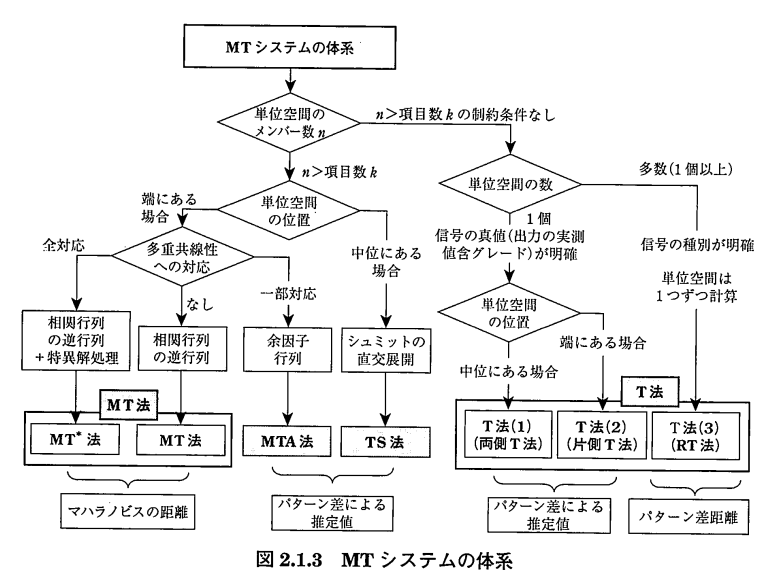

In [ ]:
from PIL import Image
filename = "./mt_system.png"
im = Image.open(filename)
im

## * MT法にてマハラノビス距離を求める手順

1. パターンを表現する変数を決める
2. サンプルを沢山集める
3. 単位空間を構成するサンプルを選択し、単位空間を定義する
    * 例えば、企業の業績診断をする場合、単位空間を決める企業をどう決めるか？　他に比べて業績が良い企業は、他には無い特徴を持っている企業と考えられるため、**業績が平凡**な企業を選んだ方が良い。平凡な企業は、良くも悪くも際立った特徴がない企業と言えるので、業績が良い企業や悪い企業よりもずっと安定した単位空間となることが期待できる。
4. 判断対象サンプルのマハラノビス距離を求める
    * 判別の閾値の決め方：(損失関数を用いるか、ドメインナレッジを用いて)判別を誤ることによって発生する損失が最小となるように閾値を決める。

## * MT法の制約
1. **`欠損値`**があると計算できない
    * 欠損レコードを捨てるか、穴埋め必要
2. **`サンプル数 < 変数数`**では計算できない
    * 変数の数を減らすか、マルチMT法で対応必要
3. 標準偏差が**`ゼロ(定数)`**の変数があると計算できない
    * 定数の変数は捨てる
4. 変数間に**`多重共線性`**があると計算出来ない
    * 変数間に強い順・逆相関があると逆行列が求められなくなる
    * 相関が強い変数を捨てるか、マルチMT法を用いる

## * MT法データ処理手順
1. 単位空間の定義に用いるサンプルと変数データを集める
2. データの欠損値を補完する
3. 変数ごとに正規化(平均0, 分散1)する
    * 変数間の単位を揃えるため正規化が必要。忘れると、単位大きい変数の影響が大きくなる
4. 変数間の相関を求めて、相関行列を作成する
5. 変数間の相関状況を確認する
    * 強相関がある変数については、削除するかMMT法を利用する
6. 相関行列の逆行列を求める
7. サンプルのマハラノビス距離を求め、閾値を決める
    * 相関行列の代わりに、分散共分散行列を用いても良いが、相関行列の方が、多重共線性のリスク確認ができるので、相関行列推奨
8. 評価対象のマハラノビス距離を求める
9. 閾値を超えているか判別する


## * MT法による異常値判別のコード例

* 変数：ph、水温、降水量、化学的酸素要求量（COD）
* 上記変数のうち、正常なレコードを抽出してマハラノビス距離を算出する
* 算出した正常レコード集団のマハラノビス距離の最大値を超えたレコードを異常値と識別する
* ダミーデータを利用


In [1]:
import numpy as np
import pandas as pd

### 1. ダミーデータ作成
* 変数名：ph, 数値範囲：4~10, 桁数：小数点1桁
* 変数名：water_temp, 数値範囲：10~60, 桁数：小数点0桁
* 変数名：rain, 数値範囲：0~100, 桁数：小数点0桁
* 変数名：cod, 数値範囲：0~10, 桁数：小数点1桁

In [2]:
np.random.seed(42)

# 変数生成
ph = np.round(np.random.uniform(4, 10, 2000), 1)          # ph: 4~10, 小数点1桁
water_temp = np.round(np.random.uniform(10, 60, 2000), 0) # water_temp: 10~60, 小数点0桁
rain = np.round(np.random.uniform(0, 100, 2000), 0)       # rain: 0~100, 小数点0桁
cod = np.round(np.random.uniform(0, 10, 2000), 1)         # COD: 0~10, 小数点1桁

data_df = pd.DataFrame({
    'ph': ph,
    'water_temp': water_temp,
    'rain': rain,
    'cod': cod
})

data_df.head()

,ph,water_temp,rain,cod
0,6.2,23.0,57.0,6.5
1,9.7,22.0,81.0,1.7
2,8.4,55.0,76.0,8.7
3,7.6,22.0,15.0,6.1
4,4.9,24.0,15.0,1.6


In [3]:
data_df.describe()

,ph,water_temp,rain,cod
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,6.991400,34.823500,49.649500,4.877700
std,1.754273,14.430193,28.806815,2.873216
min,4.000000,10.000000,0.000000,0.000000
25%,5.400000,23.000000,25.000000,2.400000
50%,7.000000,35.000000,49.000000,4.800000
75%,8.500000,47.000000,74.000000,7.400000
max,10.000000,60.000000,100.000000,10.000000


### 2. 欠損値チェック

In [4]:
missing_values = data_df.isnull().sum()

print("欠損値の合計:", missing_values.sum())
print("各列ごとの欠損値:\n", missing_values)

欠損値の合計: 0
各列ごとの欠損値:
 ph            0
water_temp    0
rain          0
cod           0
dtype: int64


### 3. 最適なサンプルデータ(正常データ)の抽出
* ph:6~10,かつ water_temp:35以下,かつ rain:50以下,かつ COD:5以下を正常データと仮定する

In [5]:
sampled_data = data_df[
    (data_df['ph'] >= 6) &
    (data_df['ph'] <= 10) &
    (data_df['water_temp'] <= 35) &
    (data_df['rain'] <= 50) &
    (data_df['cod'] <= 50)
]

In [6]:
sampled_data.describe()

,ph,water_temp,rain,cod
count,357.000000,357.000000,357.000000,357.000000
mean,8.014006,22.733894,26.218487,4.750700
std,1.187020,7.437326,14.038566,2.939527
min,6.000000,10.000000,0.000000,0.000000
25%,7.000000,16.000000,15.000000,2.100000
50%,8.100000,23.000000,27.000000,4.600000
75%,9.000000,29.000000,39.000000,7.200000
max,10.000000,35.000000,50.000000,10.000000


### 4, 5. 相関行列の作成と相関状況の確認

In [7]:
x = sampled_data.values

# 標準化
mean_val = np.mean(x, axis=0)
std_val = np.std(x, axis=0) # 分散は不偏分散ではないので、n割の分散使う
x_std = (x - mean_val) / std_val

# 相関算出
corr_matrix = np.corrcoef(x_std, rowvar=False)

# 相関確認
corr_matrix

array([[ 1.        , -0.04771753, -0.02489588,  0.13639415],
       [-0.04771753,  1.        , -0.00651723, -0.01063651],
       [-0.02489588, -0.00651723,  1.        ,  0.02572639],
       [ 0.13639415, -0.01063651,  0.02572639,  1.        ]])

* 変数が多いときは、ヒートマップなどで確認するか、指定した相関以上の変数を自動削除する？

### 6. 逆行列を求める


In [8]:
inv_corr_matrix = np.linalg.inv(corr_matrix)
inv_corr_matrix

array([[ 1.02204357,  0.04747526,  0.02934679, -0.13965078],
       [ 0.04747526,  1.00235745,  0.00761187,  0.00399042],
       [ 0.02934679,  0.00761187,  1.00154398, -0.02968787],
       [-0.13965078,  0.00399042, -0.02968787,  1.01985376]])

### 7. サンプルデータのマハラノビス距離を求める
* MT法でのマハラノビス距離は、変数の数で割って正規化することで、単位円を作る

In [9]:
# スケーリング因子
k = x_std.shape[1]

print(f"変量数：{k}")

変量数：4


In [10]:
# マハラノビス距離の算出
mahala_dists = []
for i in range(len(x_std)):
    # レコード抽出
    row = x_std[i, :]
    # マハラノビス距離の算出
    D2 = (1 / k) * np.dot(np.dot(row, inv_corr_matrix), row.T)
    mahala_dists.append(np.sqrt(D2))

# dfに保存
sampled_data['mahala_dist'] = mahala_dists

C:\Users\yoshi\AppData\Local\Temp\ipykernel_1960\3906174908.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_data['mahala_dist'] = mahala_dists


In [11]:
sampled_data.describe()

,ph,water_temp,rain,cod,mahala_dist
count,357.000000,357.000000,357.000000,357.000000,357.000000
mean,8.014006,22.733894,26.218487,4.750700,0.968366
std,1.187020,7.437326,14.038566,2.939527,0.249882
min,6.000000,10.000000,0.000000,0.000000,0.272451
25%,7.000000,16.000000,15.000000,2.100000,0.833691
50%,8.100000,23.000000,27.000000,4.600000,1.002620
75%,9.000000,29.000000,39.000000,7.200000,1.133551
max,10.000000,35.000000,50.000000,10.000000,1.708589


* マハラノビス距離の平均が1に近いので、正しくマハラノビス空間が作られている

* 異常判別の閾値は、mahara_distのmax値より2に設定する

### 8. 異常値判別
* 以下の各レコードのマハラノビス距離を求めて、閾値を超えているかどうかで異常値か判断する
    1. ph:2, water_temp:30, rain:0, cod:2 - 強酸性(異常と思われるレコード)
    2. ph:7, water_temp:55, rain:0, cod:1 - 高水温(異常と思われるレコード)
    3. ph:8, water_temp:24, rain:80, cod:1 - 高水量(異常と思われるレコード)
    4. ph:7, water_temp:55, rain:0, cod:10 - 高cod(異常と思われるレコード)
    5. ph:7, water_temp:27, rain:0, cod:1 - 正常と思われるレコード

* 注意
    * 判別対象のレコードを標準化するときは、サンプルデータの平均と分散を使う
    * 判別対象のレコードのマハラノビス距離を求めるときは、サンプルデータの逆行列を用いる

In [12]:
# 判別対象レコードのデータフレーム作成
new_records = pd.DataFrame({
    'ph': [2, 7, 8, 7, 7],
    'water_temp': [30, 55, 24, 55, 27],
    'rain': [0, 0, 80, 0, 0],
    'cod': [2, 1, 1, 10, 1]
})

# 標準化
target_rec_std = (new_records.values - mean_val) / std_val

# マハラノビス距離を計算
new_distances = []
for i in range(len(target_rec_std)):
    row = target_rec_std[i, :]
    D2 = (1 / k) * np.dot(np.dot(row, inv_corr_matrix), row.T)
    new_distances.append(np.sqrt(D2))

# 閾値設定
max_mahalanobis_distance = 2

# 新しいレコードの異常判定
new_records['mahala_dist'] = new_distances
new_records['Is_Anomalous'] = new_records['mahala_dist'] > max_mahalanobis_distance

# 結果の表示
new_records

,ph,water_temp,rain,cod,mahala_dist,Is_Anomalous
0,2,30,0,2,2.751604,True
1,7,55,0,1,2.447501,True
2,8,24,80,1,2.044927,True
3,7,55,0,10,2.585378,True
4,7,27,0,1,1.206720,False


* 最後のレコード以外は、異常値と判断された

## 散布図にて結果確認
* マハラノビス距離の分布をプロットして確認する

In [13]:
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = 'iframe' # or 'colab' or 'iframe' or 'iframe_connected' or 'sphinx_gallery'

In [14]:
sampled_data["Is_Anomalous"] = "Sample"
all_data = pd.concat([sampled_data, new_records], ignore_index=True)

C:\Users\yoshi\AppData\Local\Temp\ipykernel_1960\1456617650.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
all_data['plt_index'] = 0
all_data

,ph,water_temp,rain,cod,mahala_dist,Is_Anomalous,plt_index
0,7.6,22.0,15.0,6.1,0.519261,Sample,0
1,8.2,34.0,6.0,2.5,1.112335,Sample,0
2,9.8,13.0,39.0,8.2,1.181873,Sample,0
3,6.6,11.0,30.0,5.5,1.040076,Sample,0
4,6.3,13.0,29.0,4.0,1.003298,Sample,0
...,...,...,...,...,...,...,...
357,2.0,30.0,0.0,2.0,2.751604,True,0
358,7.0,55.0,0.0,1.0,2.447501,True,0
359,8.0,24.0,80.0,1.0,2.044927,True,0
360,7.0,55.0,0.0,10.0,2.585378,True,0


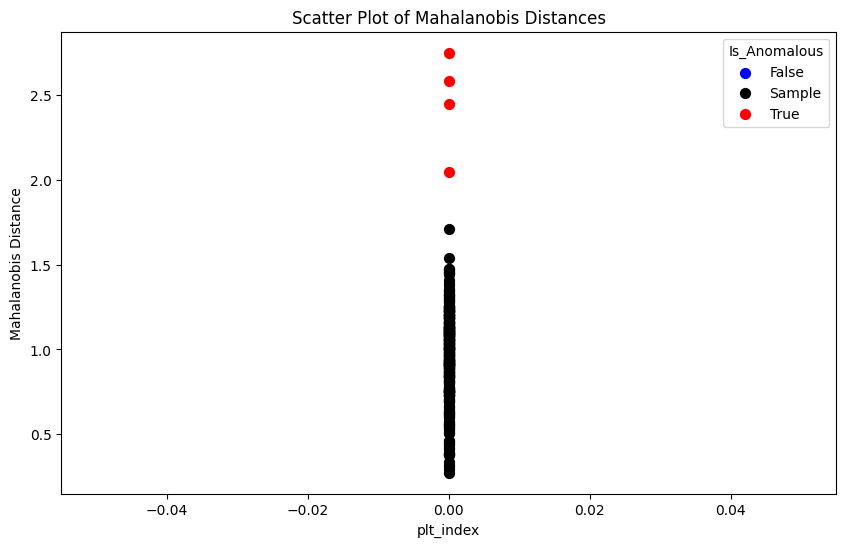

In [23]:
import matplotlib.pyplot as plt

# Is_Anomalous列を文字列型に変換（必要であれば）
all_data['Is_Anomalous'] = all_data['Is_Anomalous'].astype(str)

# データフレームをグループごとに分割
groups = all_data.groupby('Is_Anomalous')

# 色のマッピング
color_map = {'Sample': 'black', 'False': 'blue', 'True': 'red'}

# プロットの設定
plt.figure(figsize=(10, 6))
for group_name, group_data in groups:
    plt.scatter(
        group_data['plt_index'], 
        group_data['mahala_dist'], 
        label=group_name, 
        color=color_map[group_name],  # 修正済み：group_nameが文字列で対応
        s=50  # マーカーサイズ
    )

# タイトルとラベルの設定
plt.title('Scatter Plot of Mahalanobis Distances')
plt.xlabel('plt_index')
plt.ylabel('Mahalanobis Distance')

# 凡例の表示
plt.legend(title='Is_Anomalous')

# グラフの表示
plt.show()


* マハラノビス距離が2より大きいレコードを異常値として判別している

## 主成分分析で4変数を２成分に変換して異常値の分布をプロット
* 正規化後のデータを使って主成分分析にかけること

In [17]:
from sklearn.decomposition import PCA

In [18]:
sed_sample = pd.DataFrame(x_std, columns=['ph', 'water_temp', 'rain', 'cod'])
sed_target = pd.DataFrame(target_rec_std, columns=['ph', 'water_temp', 'rain', 'cod'])
sed_target['Is_Anomalous'] = new_records['Is_Anomalous']
sed_sample['Is_Anomalous'] = 'Sample'
all_scaled_data = pd.concat([sed_sample, sed_target], ignore_index=True)


In [19]:
# 主成分分析 (PCA) の実行
pca = PCA(n_components=2)  # 2次元に変換
pca_transformed = pca.fit_transform(all_scaled_data.drop(columns=['Is_Anomalous']))

# 主成分をデータフレームに追加
all_scaled_data['PCA1'] = pca_transformed[:, 0]
all_scaled_data['PCA2'] = pca_transformed[:, 1]

In [20]:
all_scaled_data

,ph,water_temp,rain,cod,Is_Anomalous,PCA1,PCA2
0,-0.349267,-0.098816,-0.800241,0.459664,Sample,-0.148804,-0.492753
1,0.156910,1.516932,-1.442232,-0.766742,Sample,-1.399245,-1.421772
2,1.506715,-1.310626,0.911735,1.175067,Sample,2.511385,0.222975
3,-1.192895,-1.579918,0.269744,0.255263,Sample,0.247344,1.373384
4,-1.445983,-1.310626,0.198412,-0.255740,Sample,-0.320263,1.498074
...,...,...,...,...,...,...,...
357,-5.073584,0.978350,-1.870226,-0.937076,True,-4.782167,0.598048
358,-0.855444,4.344490,-1.870226,-1.277744,True,-3.869174,-2.658167
359,-0.011816,0.170476,3.836360,-1.277744,True,0.399195,2.798457
360,-0.855444,4.344490,-1.870226,1.788270,True,-2.408034,-4.010140


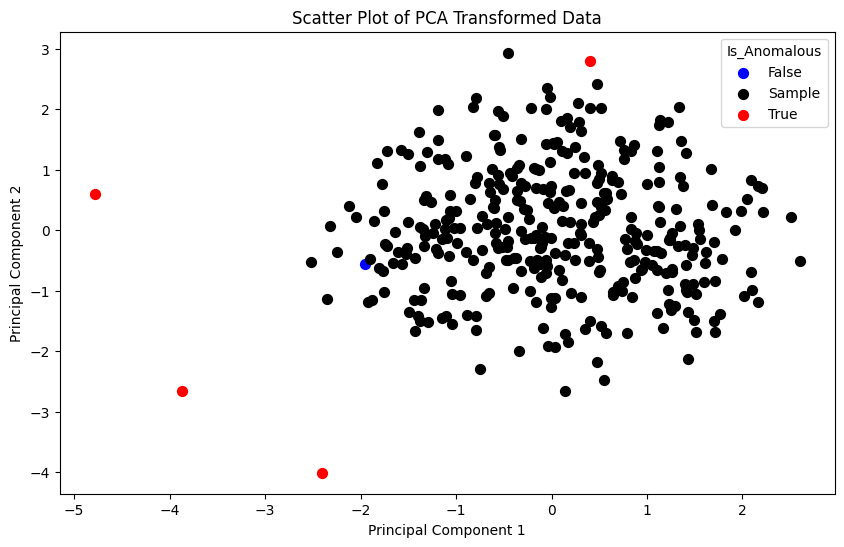

In [24]:
import matplotlib.pyplot as plt

# Is_Anomalous列を文字列型に変換（必要であれば）
all_scaled_data['Is_Anomalous'] = all_scaled_data['Is_Anomalous'].astype(str)

# データフレームをグループごとに分割
groups = all_scaled_data.groupby('Is_Anomalous')

# 色のマッピング
color_map = {'Sample': 'black', 'False': 'blue', 'True': 'red'}

# プロットの設定
plt.figure(figsize=(10, 6))
for group_name, group_data in groups:
    plt.scatter(
        group_data['PCA1'], 
        group_data['PCA2'], 
        label=group_name, 
        color=color_map.get(group_name, 'gray'),  # デフォルト色を設定
        s=50  # マーカーサイズ
    )

# タイトルとラベルの設定
plt.title('Scatter Plot of PCA Transformed Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# 凡例の表示
plt.legend(title='Is_Anomalous')

# グラフの表示
plt.show()


* 1点、正常集団の分布に近い異常値判定を受けたレコードが存在する。
    * 異常値の閾値を厳しく設定すると上記のようになるので、閾値の設定をゆるくするか厳しくするか検討必要